In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider

from tqdm import tqdm

In [2]:
def init_state(N, d):
    coords = np.random.rand(N, d) * N - N / 2
    velocities = np.random.randn(N, d) * 2
    return np.stack((coords, velocities), axis=2)


# canonical
def update_coordinates(state, update_params):
    time_rate = update_params["time_rate"]
    state[:,:,0] += state[:,:,1] * time_rate
    return state


def update_velocities(state, update_params):
    vel_prev_coef = update_params["vel_prev_coef"]
    vel_to_center_coef = update_params["vel_to_center_coef"]
    vel_average_coef = update_params["vel_average_coef"]
    
    vel_prev = state[:,:,1]
    swarm_center = state[:,:,0].mean(axis=0, keepdims=True)
    vel_to_center = swarm_center - state[:,:,0]
    vel_average = state[:,:,1].mean(axis=0, keepdims=True)
    state[:,:,1] = vel_prev * vel_prev_coef + vel_to_center * vel_to_center_coef + vel_average * vel_average_coef
    return state


def normalize_velocities(vel):
    return vel / np.sqrt((vel ** 2 + 1e-8).sum(axis=1,keepdims=True))


def normalize_velocity(vel):
    return vel / np.sqrt((vel ** 2 + 1e-8).sum())


def calc_logs(state):
    return dict(
        state=np.copy(state),
    )


def plot_state(state):
    plt.quiver(*(state[:,:,0].T), *(state[:,:,1].T))
    plt.show()
    

def plot_dynamics(log, gif_filename='./animation.gif', fps=10):
    """
    Inspiration from
    https://towardsdatascience.com/intro-to-dynamic-visualization-with-python-animations-and-interactive-plots-f72a7fb69245
    """
    
    # Animation function
    def update_quiver(i, Q, ax, log):
        state = log[i]["state"]
        Q.set_offsets(state[:,:,0])
        Q.set_UVC(*(normalize_velocities(state[:,:,1]).T))

        ax.set_xlim(np.round(state[:,0,0].min(), -1) - 10, np.round(state[:,0,0].max(), -1) + 10)
        ax.set_ylim(np.round(state[:,1,0].min(), -1) - 10, np.round(state[:,1,0].max(), -1) + 10)
        return Q,

    # Create figure and add axes
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    ax.grid()
    state = log[0]["state"]
    Q = ax.quiver(*(state[:,:,0].T), *(state[:,:,1].T))

    anim = FuncAnimation(fig, update_quiver, fargs=(Q, ax, log), frames=max_iters,
                                   interval=10, blit=False)
    fig.tight_layout()
    #plt.show()

    anim.save(gif_filename, writer='imagemagick', fps=fps)

In [3]:
class SwarmSimulator:
    
    def __init__(self, init_state, update_coordinates, update_velocities, calc_logs, plot_dynamics):
        self.init_state = init_state
        self.update_coordinates = update_coordinates
        self.update_velocities = update_velocities
        self.calc_logs = calc_logs
        self.plot_dynamics = plot_dynamics
    
    def run_system(self, init_params, update_params, max_iters, gif_filename=None, fps=10):
        state = self.init_state(**init_params)
        log = []
        log.append(self.calc_logs(state))

        for i in tqdm(range(max_iters)):
            state = self.update_coordinates(state, update_params)
            state = self.update_velocities(state, update_params)
            log.append(self.calc_logs(state))
        if gif_filename:
            self.plot_dynamics(log, gif_filename=gif_filename, fps=fps)
        return state, log

In [39]:
np.arange(5).dot(np.arange(5))

30

In [4]:
def vector_to_local_particles(particle, state, distance, **kwargs):
    N, d, _ = state.shape
    distances = np.sqrt(np.sum((particle[:,0].reshape(1, -1) - state[:,:,0]) ** 2, axis=1))
    local_particles = state[distances < distance][:,:,0]
    return local_particles.mean(axis=0) - particle[:,0]


def vector_like_local_velocities(particle, state, distance, **kwargs):
    distances = np.sqrt(np.sum((particle[:,0].reshape(1, -1) - state[:,:,0]) ** 2, axis=1))
    local_velocities = state[distances < distance][:,:,1]
    return local_velocities.mean(axis=0)


def vector_to_point_in_space(particle, point, **kwargs):
    return point - particle[:,0]


def velocity_vector(particle, **kwargs):
    return particle[:,1]


def vector_from_hyperplane(particle, hyperplane, offset, **kwargs):
    """
    Input:
        particle: Tensor of shape d x 2
        hyperplane: Vector of shape d. 
            It describes a set of points that satisfy equation hyperplane.dot(point) = 0.
        offset: Float
    Returns:
        Vector of shape d    
    """
    if hyperplane.dot(particle[:,0]) < offset:
        return hyperplane
    return np.zeros(particle.shape[0])


def get_available_vector_functions():
    return [
        vector_to_local_particles,
        vector_like_local_velocities,
        vector_to_point_in_space,
        velocity_vector,
        vector_from_hyperplane,
    ]

Допустим, мы хотим отсечь в двумерном пространстве полуплоскость x < 0. Тогда вектор hyperplane будет $(1, 0)$. А offset будет равен нулю.

In [5]:
def update_velocities_boid(state, update_params=dict()):
    """
    Input:
        state: Tensor N x d x 2, where state[:,:,0] are coordinates, state[:,:,1] are velocities
        update_params: dict, with params for function updating velocities
    Return:
        state: Tensor N x d x 2 with updated velocities
    """
    
    time_rate = update_params["time_rate"]
    config = update_params["velocities_config"]
    for i, particle in enumerate(state):
        new_velocity = 0
        for params in config:
            func = params["func"]
            coef = params["coef"]
            dist = params.get("dist")
            # point = params.get("point")
            vector = func(
                particle=particle,
                state=state,
                distance=dist,
                **params
            )
            vector = normalize_velocity(vector)
            vector = coef * vector
            new_velocity += vector
        state[i,:,1] = new_velocity
    return state

In [67]:
simulator_v1 = SwarmSimulator(init_state, update_coordinates, update_velocities_boid, calc_logs, plot_dynamics)

In [68]:
get_available_vector_functions()

[<function __main__.vector_to_local_particles(particle, state, distance, **kwargs)>,
 <function __main__.vector_like_local_velocities(particle, state, distance, **kwargs)>,
 <function __main__.vector_to_point_in_space(particle, point, **kwargs)>,
 <function __main__.velocity_vector(particle, **kwargs)>,
 <function __main__.vector_from_hyperplane(particle, hyperplane, offset, **kwargs)>]

## Experiments

100%|████████████████████████████████████████| 200/200 [00:08<00:00, 26.36it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


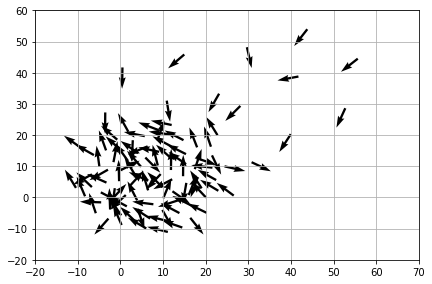

In [38]:
max_iters = 200
init_params = dict(N=100, d=2)
velocities_config = [
    dict(func=vector_to_local_particles, dist=3, coef=-1.), # collisions
    dict(func=vector_like_local_velocities, dist=7, coef=.5), # sync with neighbours
    dict(func=vector_to_local_particles, dist=15, coef=-0.3), # local clustering
    dict(func=vector_to_local_particles, dist=np.inf, coef=0.25), # global clustering
    dict(func=vector_to_point_in_space, dist=None, coef=0.2, point=np.zeros(2)), # to zero
    dict(func=velocity_vector, dist=None, coef=0.2, point=np.zeros(2)), # prev
]

update_params = dict(
    velocities_config=velocities_config,
    time_rate=0.6,
)

state, log = simulator_v1.run_system(init_params, update_params, max_iters,
                                     gif_filename='./gifs/v3.1.gif')

100%|████████████████████████████████████████| 200/200 [00:09<00:00, 20.78it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


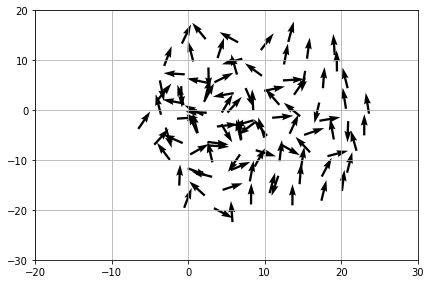

In [58]:
gif_filename='./gifs/v3.2.borders.gif'
max_iters = 200
init_params = dict(N=100, d=2)
velocities_config = [
    dict(func=vector_to_local_particles, dist=3, coef=-1.), # collisions
    dict(func=vector_like_local_velocities, dist=7, coef=.5), # sync with neighbours
    dict(func=vector_to_local_particles, dist=15, coef=-0.3), # local clustering
    dict(func=vector_to_local_particles, dist=np.inf, coef=0.25), # global clustering
    dict(func=vector_to_point_in_space, dist=None, coef=0.2, point=np.zeros(2)), # to zero
    dict(func=velocity_vector, dist=None, coef=0.2, point=np.zeros(2)), # prev
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([1,0]), offset=0), # borders
]

update_params = dict(
    velocities_config=velocities_config,
    time_rate=0.6,
)

state, log = simulator_v1.run_system(init_params, update_params, max_iters, gif_filename=gif_filename)

100%|████████████████████████████████████████| 200/200 [00:09<00:00, 20.10it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


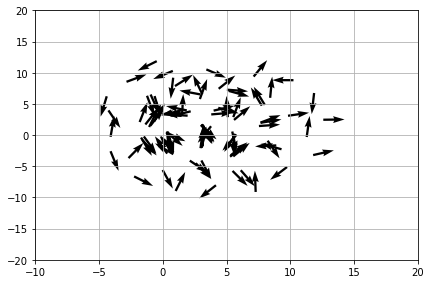

In [59]:
gif_filename='./gifs/v3.3.borders.gif'
max_iters = 200
init_params = dict(N=100, d=2)
velocities_config = [
    dict(func=vector_to_local_particles, dist=3, coef=-0.3), # collisions
    dict(func=vector_like_local_velocities, dist=7, coef=.1), # sync with neighbours
    dict(func=vector_to_local_particles, dist=15, coef=0.), # local clustering
    dict(func=vector_to_local_particles, dist=np.inf, coef=0.1), # global clustering
    dict(func=vector_to_point_in_space, dist=None, coef=0.1, point=np.zeros(2)), # to zero
    dict(func=velocity_vector, dist=None, coef=1, point=np.zeros(2)), # prev
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([1,0]), offset=0), # borders
]

update_params = dict(
    velocities_config=velocities_config,
    time_rate=0.6,
)

state, log = simulator_v1.run_system(init_params, update_params, max_iters, gif_filename=gif_filename)

In [75]:
simulator_v2 = SwarmSimulator(init_state, update_coordinates, update_velocities_boid, calc_logs, plot_dynamics)

100%|████████████████████████████████████████| 100/100 [00:05<00:00, 18.64it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


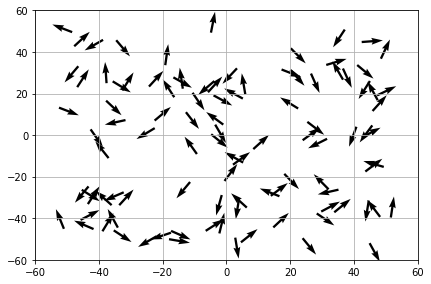

In [78]:
gif_filename='./gifs/v3.4.borders.gif'
max_iters = 100
init_params = dict(N=100, d=2)
velocities_config = [
    dict(func=vector_to_local_particles, dist=3, coef=-0.), # collisions
    dict(func=vector_like_local_velocities, dist=7, coef=.0), # sync with neighbours
    dict(func=vector_to_local_particles, dist=15, coef=0.), # local clustering
    dict(func=vector_to_local_particles, dist=np.inf, coef=0.), # global clustering
    dict(func=vector_to_point_in_space, dist=None, coef=0., point=np.zeros(2)), # to zero
    dict(func=velocity_vector, dist=None, coef=1, point=np.zeros(2)), # prev
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([1,0]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([-1,0]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([0,1]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([0,-1]), offset=50), # borders
]

update_params = dict(
    velocities_config=velocities_config,
    time_rate=0.7,
)

state, log = simulator_v2.run_system(init_params, update_params, max_iters, gif_filename=gif_filename)

100%|████████████████████████████████████████| 300/300 [00:16<00:00, 19.47it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


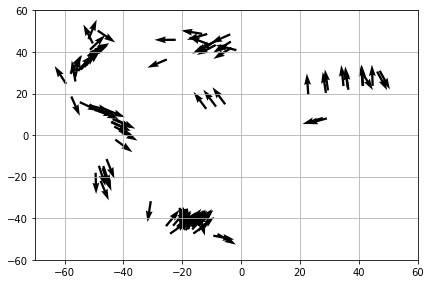

In [81]:
gif_filename='./gifs/v3.5.borders.syncing.gif'
max_iters = 300
fps = 15
init_params = dict(N=100, d=2)
velocities_config = [
    dict(func=vector_to_local_particles, dist=3, coef=-0.), # collisions
    dict(func=vector_like_local_velocities, dist=7, coef=.1), # sync with neighbours
    dict(func=vector_to_local_particles, dist=15, coef=0.), # local clustering
    dict(func=vector_to_local_particles, dist=np.inf, coef=0.), # global clustering
    dict(func=vector_to_point_in_space, dist=None, coef=0., point=np.zeros(2)), # to zero
    dict(func=velocity_vector, dist=None, coef=1, point=np.zeros(2)), # prev
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([1,0]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([-1,0]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([0,1]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([0,-1]), offset=50), # borders
]

update_params = dict(
    velocities_config=velocities_config,
    time_rate=0.7,
)

state, log = simulator_v2.run_system(init_params, update_params, max_iters, gif_filename=gif_filename, fps=fps)

еееее, я уже очень близко

отражение от краёв дало мне как раз ту нужную хаотичность (привет задача о бильярде)

100%|████████████████████████████████████████| 300/300 [00:56<00:00,  4.49it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


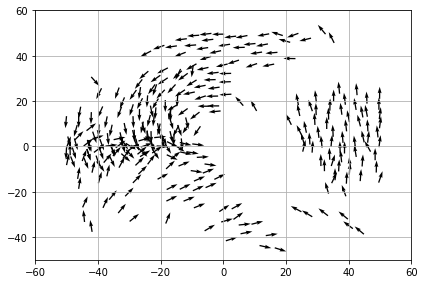

In [83]:
gif_filename='./gifs/v3.6.borders.syncing.distancing.gif'
max_iters = 300
fps = 15
init_params = dict(N=300, d=2)
velocities_config = [
    dict(func=vector_to_local_particles, dist=4, coef=-0.1), # collisions
    dict(func=vector_like_local_velocities, dist=7, coef=.1), # sync with neighbours
    dict(func=vector_to_local_particles, dist=15, coef=0.), # local clustering
    dict(func=vector_to_local_particles, dist=np.inf, coef=0.), # global clustering
    dict(func=vector_to_point_in_space, dist=None, coef=0., point=np.zeros(2)), # to zero
    dict(func=velocity_vector, dist=None, coef=1, point=np.zeros(2)), # prev
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([1,0]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([-1,0]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([0,1]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([0,-1]), offset=50), # borders
]

update_params = dict(
    velocities_config=velocities_config,
    time_rate=0.7,
)

state, log = simulator_v2.run_system(init_params, update_params, max_iters, gif_filename=gif_filename, fps=fps)

100%|██████████████████████████████████████| 1000/1000 [03:04<00:00,  5.47it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


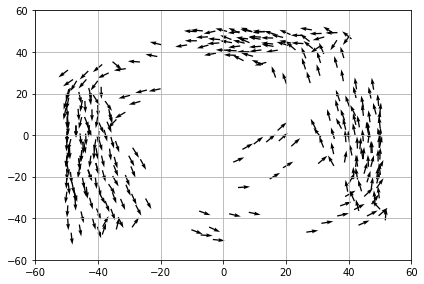

In [84]:
gif_filename='./gifs/v3.7.borders.syncing.distancing.gif'
max_iters = 1000
fps = 15
init_params = dict(N=300, d=2)
velocities_config = [
    dict(func=vector_to_local_particles, dist=4, coef=-0.1), # collisions
    dict(func=vector_like_local_velocities, dist=7, coef=.1), # sync with neighbours
    dict(func=vector_to_local_particles, dist=15, coef=0.), # local clustering
    dict(func=vector_to_local_particles, dist=np.inf, coef=0.), # global clustering
    dict(func=vector_to_point_in_space, dist=None, coef=0., point=np.zeros(2)), # to zero
    dict(func=velocity_vector, dist=None, coef=1, point=np.zeros(2)), # prev
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([1,0]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([-1,0]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([0,1]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([0,-1]), offset=50), # borders
]

update_params = dict(
    velocities_config=velocities_config,
    time_rate=0.7,
)

state, log = simulator_v2.run_system(init_params, update_params, max_iters, gif_filename=gif_filename, fps=fps)

In [8]:
def init_state(N, d, low=None, high=None):
    if not low:
        low = - N / 2
    if not high:
        high = N / 2
    coords = np.random.rand(N, d) * (high - low) + low
    velocities = np.random.randn(N, d) * 2
    return np.stack((coords, velocities), axis=2)

In [9]:
simulator_v3 = SwarmSimulator(init_state, update_coordinates, update_velocities_boid, calc_logs, plot_dynamics)

100%|████████████████████████████████████████| 800/800 [02:32<00:00,  5.18it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


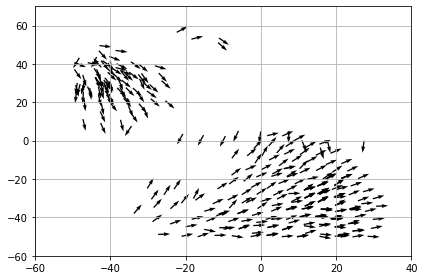

In [92]:
gif_filename='./gifs/v3.8.borders.syncing.distancing.gif'
max_iters = 800
fps = 20
init_params = dict(N=300, d=2, low=-100, high=100)
velocities_config = [
    dict(func=vector_to_local_particles, dist=4, coef=-0.1), # collisions
    dict(func=vector_like_local_velocities, dist=7, coef=.1), # sync with neighbours
    dict(func=vector_to_local_particles, dist=15, coef=0.), # local clustering
    dict(func=vector_to_local_particles, dist=np.inf, coef=0.), # global clustering
    dict(func=vector_to_point_in_space, dist=None, coef=0., point=np.zeros(2)), # to zero
    dict(func=velocity_vector, dist=None, coef=1, point=np.zeros(2)), # prev
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([1,0]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([-1,0]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([0,1]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([0,-1]), offset=50), # borders
]

update_params = dict(
    velocities_config=velocities_config,
    time_rate=0.7,
)

state, log = simulator_v3.run_system(init_params, update_params, max_iters, gif_filename=gif_filename, fps=fps)

**TODO:** поправить границы


100%|████████████████████████████████████████| 800/800 [00:19<00:00, 41.42it/s]MovieWriter imagemagick unavailable; using Pillow instead.


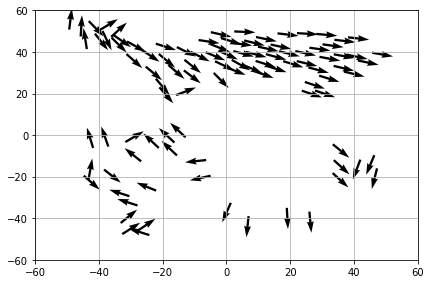

In [12]:
gif_filename='./gifs/v3.9.borders.syncing.distancing.gif'
max_iters = 800
fps = 20
init_params = dict(N=100, d=2, low=-50, high=50)
velocities_config = [
    dict(func=vector_to_local_particles, dist=4, coef=-0.1), # collisions
    dict(func=vector_like_local_velocities, dist=7, coef=.1), # sync with neighbours
    dict(func=vector_to_local_particles, dist=15, coef=0.), # local clustering
    dict(func=vector_to_local_particles, dist=np.inf, coef=0.), # global clustering
    dict(func=vector_to_point_in_space, dist=None, coef=0., point=np.zeros(2)), # to zero
    dict(func=velocity_vector, dist=None, coef=1, point=np.zeros(2)), # prev
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([1,0]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([-1,0]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([0,1]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([0,-1]), offset=50), # borders
]

update_params = dict(
    velocities_config=velocities_config,
    time_rate=0.7,
)

state, log = simulator_v3.run_system(init_params, update_params, max_iters, gif_filename=gif_filename, fps=fps)



  0%|                                                  | 0/800 [00:00<?, ?it/s]

  1%|▎                                         | 7/800 [00:00<00:12, 63.59it/s]

  2%|▋                                        | 14/800 [00:00<00:12, 63.86it/s]

  3%|█▏                                       | 22/800 [00:00<00:11, 66.61it/s]

  4%|█▍                                       | 29/800 [00:00<00:11, 67.39it/s]

  5%|█▉                                       | 37/800 [00:00<00:11, 68.56it/s]

  6%|██▎                                      | 44/800 [00:00<00:11, 68.39it/s]

  6%|██▋                                      | 52/800 [00:00<00:10, 70.17it/s]

  8%|███                                      | 60/800 [00:00<00:10, 71.26it/s]

  8%|███▍                                     | 67/800 [00:00<00:10, 69.81it/s]

  9%|███▊                                     | 74/800 [00:01<00:11, 64.90it/s]

 10%|████▏                                    | 81/800 [00:01<00:11, 64.76it/s]

 11%|████▌                

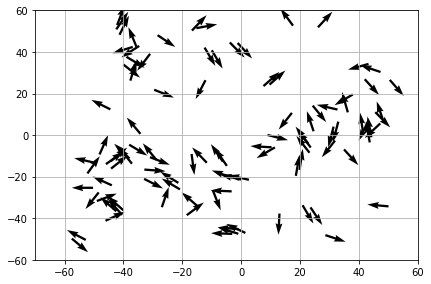

In [14]:
gif_filename='./gifs/v3.10.borders.syncing.distancing.gif'
max_iters = 800
fps = 20
init_params = dict(N=100, d=2, low=-50, high=50)
velocities_config = [
    dict(func=vector_to_local_particles, dist=2, coef=-0.1), # collisions
    dict(func=vector_like_local_velocities, dist=3, coef=.1), # sync with neighbours
    # dict(func=vector_to_local_particles, dist=15, coef=0.), # local clustering
    # dict(func=vector_to_local_particles, dist=np.inf, coef=0.), # global clustering
    # dict(func=vector_to_point_in_space, dist=None, coef=0., point=np.zeros(2)), # to zero
    dict(func=velocity_vector, dist=None, coef=1, point=np.zeros(2)), # prev
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([1,0]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([-1,0]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([0,1]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([0,-1]), offset=50), # borders
]

update_params = dict(
    velocities_config=velocities_config,
    time_rate=0.7,
)

state, log = simulator_v3.run_system(init_params, update_params, max_iters, gif_filename=gif_filename, fps=fps)



  0%|                                                 | 0/5000 [00:00<?, ?it/s]

  0%|                                         | 6/5000 [00:00<01:29, 56.06it/s]

  0%|                                        | 12/5000 [00:00<01:27, 56.86it/s]

  0%|▏                                       | 18/5000 [00:00<01:26, 57.27it/s]

  0%|▏                                       | 25/5000 [00:00<01:22, 60.52it/s]

  1%|▎                                       | 32/5000 [00:00<01:19, 62.74it/s]

  1%|▎                                       | 40/5000 [00:00<01:14, 66.42it/s]

  1%|▍                                       | 47/5000 [00:00<01:13, 67.26it/s]

  1%|▍                                       | 54/5000 [00:00<01:13, 67.27it/s]

  1%|▍                                       | 61/5000 [00:00<01:13, 67.49it/s]

  1%|▌                                       | 68/5000 [00:01<01:13, 67.05it/s]

  2%|▌                                       | 75/5000 [00:01<01:14, 66.17it/s]

  2%|▋                    

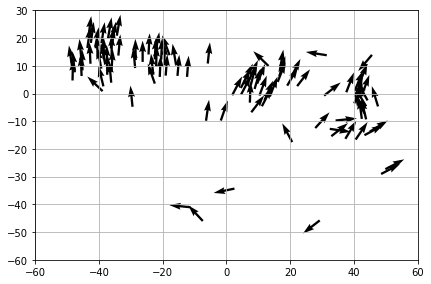

In [15]:
gif_filename='./gifs/v3.10.borders.syncing.distancing.gif'
max_iters = 5000
fps = 20
init_params = dict(N=100, d=2, low=-50, high=50)
velocities_config = [
    dict(func=vector_to_local_particles, dist=2, coef=-0.1), # collisions
    dict(func=vector_like_local_velocities, dist=3, coef=.1), # sync with neighbours
    # dict(func=vector_to_local_particles, dist=15, coef=0.), # local clustering
    # dict(func=vector_to_local_particles, dist=np.inf, coef=0.), # global clustering
    # dict(func=vector_to_point_in_space, dist=None, coef=0., point=np.zeros(2)), # to zero
    dict(func=velocity_vector, dist=None, coef=1, point=np.zeros(2)), # prev
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([1,0]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([-1,0]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([0,1]), offset=50), # borders
    dict(func=vector_from_hyperplane, coef=0.3, hyperplane=np.array([0,-1]), offset=50), # borders
]

update_params = dict(
    velocities_config=velocities_config,
    time_rate=0.7,
)

state, log = simulator_v3.run_system(init_params, update_params, max_iters, gif_filename=gif_filename, fps=fps)

**Заметки**

Текущая проблема в том, что иногда частицы слишком сильно кучкуются. Надо усилить отторжение на малых дистанциях. А также на всякий случай уменьшить time_rate, чтобы не было скачков и разрывов.

In [16]:
import glob

glob.glob('gif')

[]

In [24]:
glob.glob('*gifs/*2*')

['gifs\\introduce-local-dynamics-v2.gif',
 'gifs\\new-local-dynamics-v12.gif',
 'gifs\\new-local-dynamics-v2.gif',
 'gifs\\new-local-dynamics-v20.gif',
 'gifs\\new-local-dynamics-v21.gif',
 'gifs\\new-local-dynamics-v22.gif',
 'gifs\\new-local-dynamics-v23.gif',
 'gifs\\new-local-dynamics-v24.gif',
 'gifs\\v3.2.borders.gif']